In [ ]:
%pip install psycopg2 pymysql numpy pandas seaborn matplotlib scipy scikit-learn

In [168]:
import os
import pymysql
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv
from sklearn.datasets import load_iris
from scipy.spatial.distance import euclidean
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor

load_dotenv()
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width']

In [169]:
def getMySQL():
    mysql_url = os.getenv("MYSQL_URL")
    engine = create_engine(mysql_url)
    with engine.connect() as conn:
        df = pd.read_sql("SELECT * FROM iris_mysql", conn)
    return df

def getPostgre():
    postgres_url = os.getenv("POSTGRES_URL")
    engine = create_engine(postgres_url)
    with engine.connect() as conn:
        df = pd.read_sql("SELECT * FROM iris_postgre ORDER BY id", conn)
    return df

In [170]:
df_mysql = getMySQL()
df_postgresql = getPostgre()

# Gabungkan berdasarkan kolom 'id' dan 'Class'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")
df_contoh = df_merged.drop(columns=["id", "class"])
print(df_contoh)
df = df_contoh

# Ambil data fitur numerik
feature_columns = ["petal length", "petal width", "sepal length", "sepal width"]
data_values = df_merged[feature_columns].values

K = 3  # Jumlah tetangga terdekat
nbrs = NearestNeighbors(n_neighbors=K+1, metric='euclidean').fit(data_values)
distances, indices = nbrs.kneighbors(data_values)

# Ambil rata-rata jarak ke K tetangga terdekat (tidak termasuk jarak ke dirinya sendiri)
df_merged["knn_distance"] = np.mean(distances[:, 1:], axis=1)

# Tentukan threshold outlier berdasarkan persentil ke-95
threshold = np.percentile(df_merged["knn_distance"], 95)
df_merged["outlier"] = df_merged["knn_distance"] > threshold


     petal length  petal width  sepal length  sepal width
0            86.4         70.0          20.1         30.5
1             1.4          0.2           4.9          3.0
2             1.3          0.2           4.8          3.2
3             1.5          0.2           4.6          3.1
4             1.4          0.2           5.0          3.6
..            ...          ...           ...          ...
145           5.2          2.3           6.7          3.0
146           5.0          1.9           6.3          2.5
147           5.2          2.0           6.5          3.0
148           5.4          2.3           6.2          3.4
149           5.1          1.8           5.9          3.0

[150 rows x 4 columns]


In [171]:
print("10 Data Sepal:")
print(df_merged[["id", "class", "sepal length", "sepal width", "outlier"]].head(10).to_string(index=False))

print("\n10 Data Petal:")
print(df_merged[["id", "class", "petal length", "petal width", "outlier"]].head(10).to_string(index=False))

10 Data Sepal:
 id       class  sepal length  sepal width  outlier
  1 Iris-setosa          20.1         30.5     True
  2 Iris-setosa           4.9          3.0    False
  3 Iris-setosa           4.8          3.2    False
  4 Iris-setosa           4.6          3.1    False
  5 Iris-setosa           5.0          3.6    False
  6 Iris-setosa           5.4          3.9    False
  7 Iris-setosa           4.6          3.4    False
  8 Iris-setosa           5.0          3.4    False
  9 Iris-setosa           4.4          2.9    False
 10 Iris-setosa           4.9          3.1    False

10 Data Petal:
 id       class  petal length  petal width  outlier
  1 Iris-setosa          86.4         70.0     True
  2 Iris-setosa           1.4          0.2    False
  3 Iris-setosa           1.3          0.2    False
  4 Iris-setosa           1.5          0.2    False
  5 Iris-setosa           1.4          0.2    False
  6 Iris-setosa           1.7          0.4    False
  7 Iris-setosa           1.4    

In [172]:
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# Ambil data fitur numerik
feature_columns = ["petal length", "petal width", "sepal length", "sepal width"]
data_values = df_merged[feature_columns].values

# KNN Outlier Detection
K = 3
nbrs = NearestNeighbors(n_neighbors=K+1, metric='euclidean').fit(data_values)
distances, _ = nbrs.kneighbors(data_values)
df_merged["knn_distance"] = np.mean(distances[:, 1:], axis=1)  # Rata-rata jarak ke tetangga
threshold = np.percentile(df_merged["knn_distance"], 95)
df_merged["knn_outlier"] = df_merged["knn_distance"] > threshold

# LOF Outlier Detection
clf = LocalOutlierFactor(n_neighbors=3)
df_merged["lof_score"] = -clf.fit_predict(data_values)
df_merged["lof_outlier"] = df_merged["lof_score"] > np.percentile(df_merged["lof_score"], 95)

# Gabungkan hasil deteksi outlier
df_merged["outlier"] = df_merged["knn_outlier"] | df_merged["lof_outlier"]



print(df_merged.columns)  # Untuk melihat semua kolom yang tersedia

Index(['id', 'class', 'petal length', 'petal width', 'sepal length',
       'sepal width', 'knn_distance', 'outlier', 'knn_outlier', 'lof_score',
       'lof_outlier'],
      dtype='object')


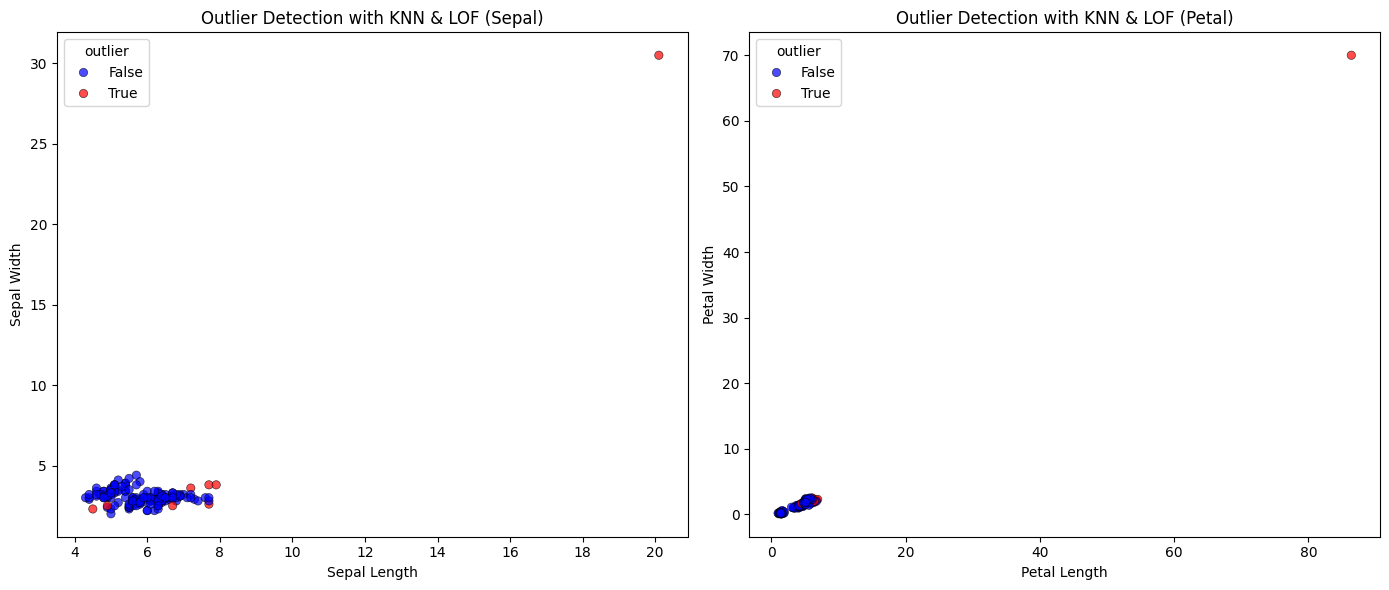

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot Sepal
sns.scatterplot(
    ax=axes[0], x=df_merged["sepal length"], y=df_merged["sepal width"],
    hue=df_merged["outlier"], palette={False: "blue", True: "red"}, alpha=0.7, edgecolor="k"
)
axes[0].set_title("Outlier Detection with KNN & LOF (Sepal)")
axes[0].set_xlabel("Sepal Length")
axes[0].set_ylabel("Sepal Width")

# Scatter plot Petal
sns.scatterplot(
    ax=axes[1], x=df_merged["petal length"], y=df_merged["petal width"],
    hue=df_merged["outlier"], palette={False: "blue", True: "red"}, alpha=0.7, edgecolor="k"
)
axes[1].set_title("Outlier Detection with KNN & LOF (Petal)")
axes[1].set_xlabel("Petal Length")
axes[1].set_ylabel("Petal Width")

plt.tight_layout()
plt.show()

In [ ]:
outliers = df_merged[df_merged["outlier"] == True][["id", "class", "knn_distance"]].reset_index(drop=True)
outliers.insert(0, "No", range(1, len(outliers) + 1))
print("\nData Outlier:")
print(outliers.to_string(index=False))


Data Outlier:
 No  id          class  knn_distance
  1   1    Iris-setosa    108.837746
  2  42    Iris-setosa      0.702252
  3 107 Iris-virginica      0.763383
  4 109 Iris-virginica      0.591073
  5 110 Iris-virginica      0.670128
  6 118 Iris-virginica      0.697026
  7 119 Iris-virginica      0.618153
  8 132 Iris-virginica      0.740949


In [ ]:
x = df[['petal length', 'petal width', 'sepal length', 'sepal width']]
# print(df)
clf = LocalOutlierFactor(n_neighbors=3)
y_pred = clf.fit_predict(x)
print(y_pred)

[-1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]


In [ ]:
df_merged["lof_outlier"] = y_pred  # LOF: -1 = outlier, 1 = inlier

# Cek jumlah outlier di setiap metode
knn_outliers = df_merged["outlier"].sum()
lof_outliers = (df_merged["lof_outlier"] == -1).sum()

print(f"Total Outlier (KNN): {knn_outliers}")
print(f"Total Outlier (LOF): {lof_outliers}")

Total Outlier (KNN): 8
Total Outlier (LOF): 13


In [ ]:
outliers_knn = df_merged[df_merged["outlier"] == True][["id", "class", "knn_distance"]].reset_index(drop=True)
outliers_knn.insert(0, "No", range(1, len(outliers_knn) + 1))

outliers_lof = df_merged[df_merged["lof_outlier"] == -1][["id", "class"]].reset_index(drop=True)
outliers_lof.insert(0, "No", range(1, len(outliers_lof) + 1))

print("\nOutlier berdasarkan KNN:")
print(outliers_knn.to_string(index=False))

print("\nOutlier berdasarkan LOF:")
print(outliers_lof.to_string(index=False))


Outlier berdasarkan KNN:
 No  id          class  knn_distance
  1   1    Iris-setosa    108.837746
  2  42    Iris-setosa      0.702252
  3 107 Iris-virginica      0.763383
  4 109 Iris-virginica      0.591073
  5 110 Iris-virginica      0.670128
  6 118 Iris-virginica      0.697026
  7 119 Iris-virginica      0.618153
  8 132 Iris-virginica      0.740949

Outlier berdasarkan LOF:
 No  id           class
  1   1     Iris-setosa
  2  21     Iris-setosa
  3  23     Iris-setosa
  4  32     Iris-setosa
  5  42     Iris-setosa
  6  60 Iris-versicolor
  7  63 Iris-versicolor
  8  65 Iris-versicolor
  9 107  Iris-virginica
 10 109  Iris-virginica
 11 110  Iris-virginica
 12 115  Iris-virginica
 13 135  Iris-virginica


In [ ]:
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")
df_contoh = df_merged.drop(columns=["id", "class"])

print("\nData Gabungan (Merge) dengan Class:")
print(df_contoh.head())


Data Gabungan (Merge) dengan Class:
   petal length  petal width  sepal length  sepal width
0          86.4         70.0          20.1         30.5
1           1.4          0.2           4.9          3.0
2           1.3          0.2           4.8          3.2
3           1.5          0.2           4.6          3.1
4           1.4          0.2           5.0          3.6


In [ ]:
data = df_contoh
id_column = data['id'] if 'id' in data.columns else None

selected_columns = ['sepal length', 'sepal width', 'petal length', 'petal width']
data = data[selected_columns]

X = data.values

from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=3, metric='euclidean')
knn.fit(X)

distances_knn, _ = knn.kneighbors(X)
mean_knn_distances = np.mean(distances_knn[:, 1:], axis=1)  # Rata-rata jarak ke tetangga

print(mean_knn_distances)

[108.74577168   0.14142136   0.2236068    0.15731322   0.17320508
   0.33903632   0.2618034    0.12071068   0.22071068   0.
   0.19142136   0.2236068    0.15731322   0.28058837   0.44067607
   0.45413884   0.35348264   0.15731322   0.35948041   0.14142136
   0.29142136   0.19318517   0.48893641   0.23228757   0.33708287
   0.2          0.2118034    0.14142136   0.14142136   0.15731322
   0.15731322   0.29142136   0.34641016   0.35348264   0.
   0.2236068    0.30811388   0.           0.17071068   0.12071068
   0.15731322   0.66932132   0.2118034    0.24409096   0.36736043
   0.17071068   0.19318517   0.18251408   0.1618034    0.15731322
   0.29811881   0.29040145   0.27370892   0.25         0.28058837
   0.30811388   0.31937043   0.26435985   0.24494897   0.44860014
   0.40940635   0.31583124   0.5047566    0.18251408   0.43573883
   0.22882456   0.25         0.26389584   0.38723854   0.20907703
   0.2618034    0.33903632   0.36055513   0.2618034    0.23228757
   0.19318517   0.33131896

In [ ]:
X = df[['petal length', 'petal width', 'sepal length', 'sepal width']]

print(X.head()) # Cek hasil
print(X.shape)
print(X)

   petal length  petal width  sepal length  sepal width
0          86.4         70.0          20.1         30.5
1           1.4          0.2           4.9          3.0
2           1.3          0.2           4.8          3.2
3           1.5          0.2           4.6          3.1
4           1.4          0.2           5.0          3.6
(150, 4)
     petal length  petal width  sepal length  sepal width
0            86.4         70.0          20.1         30.5
1             1.4          0.2           4.9          3.0
2             1.3          0.2           4.8          3.2
3             1.5          0.2           4.6          3.1
4             1.4          0.2           5.0          3.6
..            ...          ...           ...          ...
145           5.2          2.3           6.7          3.0
146           5.0          1.9           6.3          2.5
147           5.2          2.0           6.5          3.0
148           5.4          2.3           6.2          3.4
149           5.1